# Methods for Portfolio Optimization

In [135]:
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize
from scipy.optimize import linprog

### Function

In [138]:
# Funzione per calcolare il rendimento di un portafoglio
def portfolio_return(weights, mean_returns):
    return np.dot(weights, mean_returns)

# Funzione per calcolare il rischio (varianza) di un portafoglio
def portfolio_risk(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

# Funzione per minimizzare il rischio dato un livello di rendimento atteso
def minimize_risk(weights, mean_returns, cov_matrix, target_return):
    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x, mean_returns) - target_return},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for _ in range(len(mean_returns)))
    result = minimize(portfolio_risk, len(mean_returns) * [1. / len(mean_returns)], args=(cov_matrix,), 
                      method='SLSQP', bounds=bounds, constraints=constraints)
    return result

def generate_random_array(n):
    random_nums = np.random.rand(n)
    total = np.sum(random_nums)
    random_array = random_nums / total
    return random_array

import numpy as np

def calculate_gain(initial_amount, years, weekly_mean_return):
    """
    Calculates the expected gain given an initial amount, a time period in years, and the weekly mean return.

    :param initial_amount: Initial investment amount in euros.
    :param years: Time period in years.
    :param weekly_mean_return: Weekly mean return in percentage.
    :return: Final amount after the specified time period.
    """
    weeks_per_year = 52
    total_weeks = years * weeks_per_year
    weekly_return_decimal = weekly_mean_return / 100
    
    # Calculate the final gain using the compound interest formula
    final_amount = initial_amount * (1 + weekly_return_decimal) ** total_weeks
    roi = ((final_amount - initial_amount) / initial_amount) * 100

    
    return final_amount, roi

def calculate_annual_return(weekly_mean_return):
    """
    Converts weekly mean return to annual return using compound interest formula.

    :param weekly_mean_return: Weekly mean return in percentage.
    :return: Annual return in percentage.
    """
    # Convert the weekly mean return from percentage to decimal
    weekly_return_decimal = weekly_mean_return / 100
    
    # Calculate the annual return using the compound interest formula
    annual_return_decimal = (1 + weekly_return_decimal) ** 52 - 1
    
    # Convert the annual return back to percentage
    annual_return_percentage = annual_return_decimal * 100
    
    return annual_return_percentage

In [139]:
RISK_AVERSION = 0.02

## Dataset
https://www.francescocesarone.com/data-sets


### Ftse100

FTSE100 FOLDER

The folder contains the weekly linear returns for the Ftse100 from 01-22-2007 to 05-06-2013.
These returns are available into two extensions (.txt & .mat).

The files 'IndRet_Ftse100' contain a column vector which is the weekly linear returns of the market index values.

The files 'RR_Ftse100' contain a matrix where each column is the weekly linear returns of each asset.

NOTE: The returns are calculated from the weekly prices adjusted for dividends downloaded from yahoo.finance.com. 
Stocks with more than two consecutive missing values were disregarded, while the individual missing values were 
interpolated. 

In [140]:
PORTFOLIO = 'Ftse100'

mat_file_1 = 'Ftse100/IndRet_Ftse100.mat'
mat_file_2 = 'Ftse100/RR_Ftse100.mat'

mat_data_1 = scipy.io.loadmat(mat_file_1)
mat_data_2 = scipy.io.loadmat(mat_file_2)
#print(mat_data_2.keys())

array_ret = mat_data_1['Ret_ftse100'].flatten()
matrix_ret = mat_data_1['Ret_ftse100']
matrix_rr = mat_data_2['RR']

# Calcola i rendimenti medi e la matrice di covarianza
mean_returns = np.mean(matrix_rr, axis=0)
cov_matrix = np.cov(matrix_rr, rowvar=False)

nStocks = len(matrix_rr.T)

### Stoxx50

EUROSTOXX50 FOLDER

The folder contains the weekly linear returns for the Eurostoxx50 from 01-22-2007 to 05-06-2013.
These returns are available into two extensions (.txt & .mat).

The files 'IndRet_Stoxx50' contain a column vector which is the weekly linear returns of the market index values.

The files 'RR_Stoxx50' contain a matrix where each column is the weekly linear returns of each asset.

NOTE: The returns are calculated from the weekly prices adjusted for dividends downloaded from yahoo.finance.com. 
Stocks with more than two consecutive missing values were disregarded, while the individual missing values were 
interpolated. 

In [143]:
PORTFOLIO = 'EuroStoxx50'

mat_file_1 = 'EuroStoxx50/IndRet_Stoxx50.mat'
mat_file_2 = 'EuroStoxx50/RR_Stoxx50.mat'

mat_data_1 = scipy.io.loadmat(mat_file_1)
mat_data_2 = scipy.io.loadmat(mat_file_2)
#print(mat_data_2.keys())

array_ret = mat_data_1['Ret_stoxx50'].flatten()
matrix_ret = mat_data_1['Ret_stoxx50']
matrix_rr = mat_data_2['RR']

# Calcola i rendimenti medi e la matrice di covarianza
mean_returns = np.mean(matrix_rr, axis=0)
cov_matrix = np.cov(matrix_rr, rowvar=False)

nStocks = len(matrix_rr.T)

## Analytics

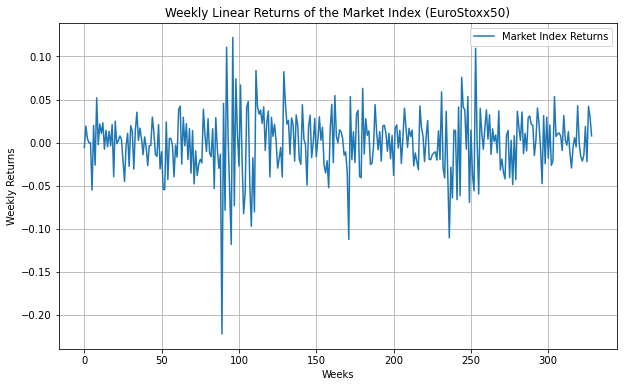

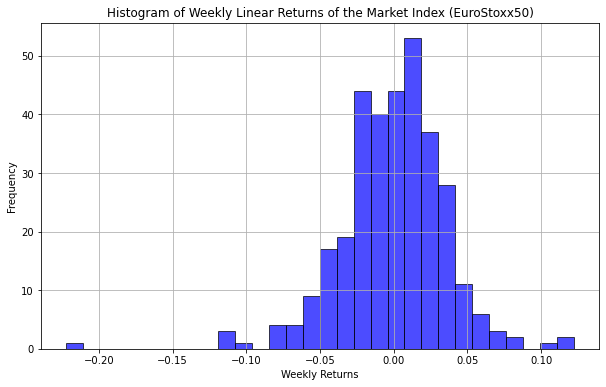

In [144]:
# Grafico del rendimento settimanale dell'indice di mercato
plt.figure(figsize=(10, 6))
plt.plot(array_ret, label='Market Index Returns')
plt.xlabel('Weeks')
plt.ylabel('Weekly Returns')
plt.title('Weekly Linear Returns of the Market Index (EuroStoxx50)')
plt.legend()
plt.grid(True)
plt.show()

# Istogramma dei rendimenti settimanali del mercato
plt.figure(figsize=(10, 6))
plt.hist(array_ret, bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.xlabel('Weekly Returns')
plt.ylabel('Frequency')
plt.title('Histogram of Weekly Linear Returns of the Market Index (EuroStoxx50)')
plt.grid(True)
plt.show()

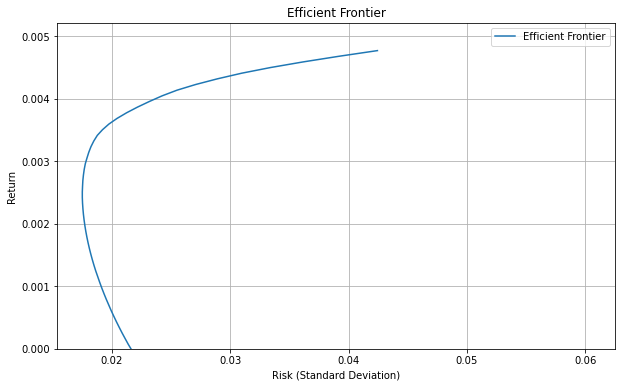

In [145]:
# Calcola la frontiera efficiente
target_returns = np.linspace(min(mean_returns), max(mean_returns), 100)
efficient_portfolios = []

for target_return in target_returns:
    efficient_portfolios.append(minimize_risk(len(mean_returns) * [1. / len(mean_returns)], mean_returns, cov_matrix, target_return))

# Estrai i rischi e i rendimenti dei portafogli efficienti
risks = [portfolio_risk(x['x'], cov_matrix) for x in efficient_portfolios]
returns = [portfolio_return(x['x'], mean_returns) for x in efficient_portfolios]

# Visualizza la frontiera efficiente
plt.figure(figsize=(10, 6))
plt.plot(risks, returns, label='Efficient Frontier')
plt.xlabel('Risk (Standard Deviation)')
plt.ylabel('Return')
plt.title('Efficient Frontier')
plt.ylim(0) 
plt.legend()
plt.grid(True)
plt.show()

## Portfolio Optimizations

We have $n$ avaiable assets. We call $w_i$ the quantity of money invested on the
$i$-th asset during the considered period and with $r_i$ the returns on the $i$-th
asset. We have two different constraints. The first one is non-negativity for the
variables (i.e., $w_i$ ≥ 0). It basically means that short selling (selling asset that
we still don’t own) is not allowed. We then have the budget constraint:

$
\begin{equation}
\sum_{i=1}^{n} w_i = B
\end{equation}
$

the total amount of money invested needs to be equal to the budget $B$ ($B$ can be simply set to 1).
Consider a stochastic model for the returns: $r ∈ R^n$ is a randomly generated vector with mean $\overline{r}$ and covariance $\Sigma$. Thus expected return will be:
$
\begin{equation}
\overline{r}^\intercal \, w
\end{equation}
$
and variance (risk)
$
\begin{equation}
w^\intercal \, \Sigma \, w
\end{equation}
$
Classic portfolio problem, described by Markowitz (1952), is a convex quadratic programming problem:
$
\begin{equation}
\begin{split}
\underset{w∈R^n}{min} \quad \gamma \, w^\intercal \, \Sigma \, w - \overline{r}^\intercal \, w \\
s.t. \quad e^\intercal w = 1 \\
w > 0
\end{split}
\end{equation} 
$
with $\gamma$ > 0 risk-aversion parameter. Goal is thus finding the set of assets that
minimizes the variance (risk connected to the given portfolio) while maximizing
the expected return (we obviously need to satisfy budget and non-negativity
constraints).

In [146]:
def checkMeanRet(weights, ret_mean):
    return np.dot(ret_mean.T, weights)

def checkSumOne(weights):
    return np.sum(weights) - 1

#def riskFunction(weights):
#    return np.dot(w.T, np.dot(cov, weights))

def loss(weights, ret_mean, cov, RISK_AVERSION):
    return  np.dot(RISK_AVERSION, np.dot(weights.T, np.dot(cov, weights))) -  np.dot(ret_mean.T, weights)

### Gradient

$
\begin{equation}
\nabla f(w_k) = 2 \, \gamma \, \Sigma \, w - \overline{r}^\intercal\\
\end{equation} 
$

In [147]:
def gradient(weights, ret_mean, cov, RISK_AVERSION):
    return  RISK_AVERSION * 2 * np.dot(weights, cov) -  ret_mean.T

## Frank-Wolfe and Pairwise Frank-Wolfe over the Markowitz portfolio problems

### Frank-Wolfe

In [148]:
def linear_solver(grad):
    c = grad # Use the positive gradient for minimization
    A_eq = np.ones((1, nStocks))
    b_eq = np.array([1])
    bounds = [(0, 1) for _ in range(nStocks)]
    res = linprog(c, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='highs')
    return res.x

def duality_gap(weights, grad):
    """
    Compute the duality gap for the given weights and gradient.
    """
    s = linear_solver(grad)
    return np.dot(grad, weights - s)

In [149]:
%%time

ITERATIONS = 20

weights = generate_random_array(nStocks)
weights_x = np.ones(nStocks) / nStocks

loss_values_fw = []
grad_values_fw = []
returns_iteration_fw = []
optimal_indices_fw = []
optimal_values_fw = []
optimal_weights_fw = []

loss_gd_improved = [loss(weights, mean_returns, cov_matrix, RISK_AVERSION)]
ret_gd_improved = [checkMeanRet(weights, mean_returns)]

prev_loss = float('inf')

for itr in range(1, ITERATIONS):
    if itr % (ITERATIONS * 0.05) == 0:
        print(f"{int(itr/ITERATIONS*100):02}%", end="")

    grad = gradient(weights, mean_returns, cov_matrix, RISK_AVERSION)
    s = linear_solver(grad)
    direction = s - weights

    # Store values for plotting
    loss_values_fw.append(loss(weights, mean_returns, cov_matrix, RISK_AVERSION))
    grad_values_fw.append(np.linalg.norm(grad))
    returns_iteration_fw.append(checkMeanRet(weights, mean_returns))

    # Find the indices of the components with the maximum value in the direction
    max_value = np.max(direction) # or np.min(direction) depending on the context
    optimal_values_fw.append(max_value)
    optimal_indices = np.where(direction == max_value)[0]
    optimal_indices_fw.append(optimal_indices.tolist())

    if abs(duality_gap(weights, grad)) < 1e-6: 
        print('Duality Gap Convergence itr: ', itr)
        break
    
    step_size = 2 / (itr + 2) #CONTROLLA 
    weights_new = weights + step_size * direction    
    current_loss = loss(weights_new, mean_returns, cov_matrix, RISK_AVERSION)

    optimal_weights_fw.append(np.max(weights_new))
    
    #norm_update = np.linalg.norm(weights_new - weights)
    #if abs(prev_loss - current_loss) < 1e-6:
    #    print('Break itr: ', itr)
    #    break

    weights = weights_new
    prev_loss = current_loss

    if itr % (ITERATIONS * 0.05) == 0:
        print(f" - ret {(returns_iteration_fw[-1])*100:05.2f}% - loss {loss(weights, mean_returns, cov_matrix, RISK_AVERSION):05.6f}")

def second_largest_partition(arr):
    return np.partition(arr, -2)[-2]

print('\n' + PORTFOLIO)
print(f"Sec Max Weights: {second_largest_partition(weights)}")
print(f"Max Weights: {np.max(weights)}")
print("Sum weights: ", np.sum(weights))

05% - ret 00.10% - loss -0.003501
10% - ret 00.35% - loss -0.004119
15% - ret 00.41% - loss -0.004366
20% - ret 00.44% - loss -0.004490
25% - ret 00.45% - loss -0.004560
30% - ret 00.46% - loss -0.004604
35% - ret 00.46% - loss -0.004634
40% - ret 00.47% - loss -0.004654
45% - ret 00.47% - loss -0.004669
50% - ret 00.47% - loss -0.004680
55% - ret 00.47% - loss -0.004689
60% - ret 00.47% - loss -0.004696
65% - ret 00.47% - loss -0.004701
70% - ret 00.47% - loss -0.004706
75% - ret 00.47% - loss -0.004709
80% - ret 00.47% - loss -0.004712
85% - ret 00.47% - loss -0.004715
90% - ret 00.48% - loss -0.004717
95% - ret 00.48% - loss -0.004719

EuroStoxx50
Sec Max Weights: 0.0002943058331268013
Max Weights: 0.9952989120196527
Sum weights:  1.0000000000000002
CPU times: user 23.7 ms, sys: 8.56 ms, total: 32.3 ms
Wall time: 38.7 ms



EuroStoxx50
Final weights: [1.86247438e-04 1.91594697e-04 9.95298912e-01 1.22820393e-04]
Sum of weights: 1.0000000000000002
Weekly Return Portfolio:  0.47545947288500706 %
Yearly Return Portfolio:  27.97349956862174 %
Max ret mean:  0.004772432179187947
Risk:  0.179 %


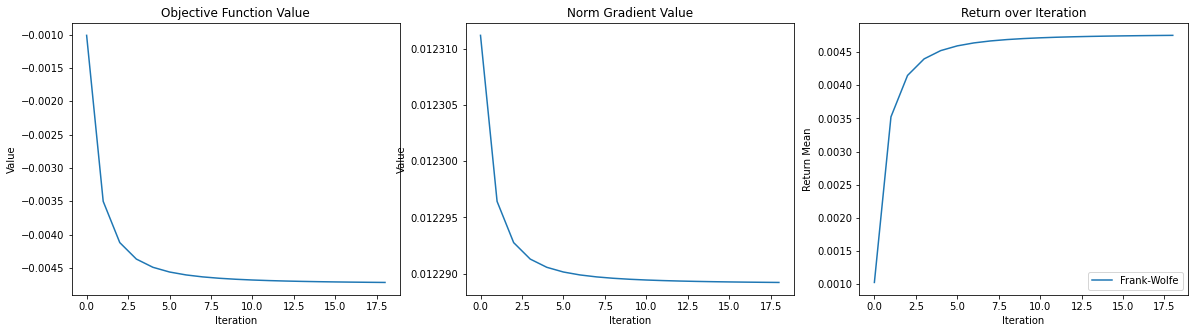

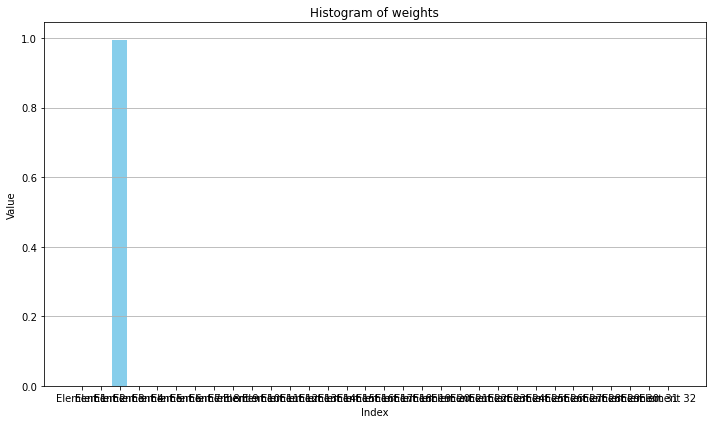

In [150]:
# Plotting the metrics
plt.figure(figsize=(20, 5))

# Loss Function Values
plt.subplot(1, 3, 1)
plt.plot(loss_values_fw)
plt.title('Objective Function Value')
plt.xlabel('Iteration')
plt.ylabel('Value')

# Norm Gradient Values
plt.subplot(1, 3, 2)
plt.plot(grad_values_fw)
plt.title('Norm Gradient Value')
plt.xlabel('Iteration')
plt.ylabel('Value')

plt.subplot(1, 3, 3)
plt.plot(returns_iteration_fw, label='Frank-Wolfe')
#plt.plot(solval_k5[0], label='Solution Retuns')
plt.title('Return over Iteration')
plt.xlabel('Iteration')
plt.ylabel('Return Mean')
plt.legend()

ret_mean_fw = checkMeanRet(weights, mean_returns) * 100
risk_fw = np.dot(weights.T, np.dot(cov_matrix, weights))*100

print('\n' + PORTFOLIO)
print("Final weights:", weights[:4])
print("Sum of weights:", np.sum(weights))
print('Weekly Return Portfolio: ', ret_mean_fw, "%")
print('Yearly Return Portfolio: ', calculate_annual_return(ret_mean_fw), "%")
print('Max ret mean: ', np.max(mean_returns))
print("Risk: ", np.round(risk_fw,3), "%")

# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.bar(range(len(weights)), weights, color='skyblue')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Histogram of weights')
plt.xticks(range(len(weights)), labels=[f'Element {i+1}' for i in range(len(weights))])
plt.grid(axis='y')

# Display the plot
plt.tight_layout()
plt.show()

In [151]:
# Example usage of the function
initial_amount = 10000  # Dollars
years = 5  # Years

final_amount, roi = calculate_gain(initial_amount, years, ret_mean_fw)
print(f"Investing {initial_amount}$ in the {PORTFOLIO} index for a total of {years} years.\n")
print(f"Final amount after {years} years: {round(final_amount)}$")
print(f"ROI: {roi:.2f} %")

Investing 10000$ in the EuroStoxx50 index for a total of 5 years.

Final amount after 5 years: 34324$
ROI: 243.24 %
